In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import scipy.signal as sig
import scipy.integrate as sint

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# import torch.optim as optim

from einops import rearrange, repeat, reduce

# from statsmodels.tsa.stattools import adfuller, kpss
# from statsmodels.tsa.statespace.tools import diff

# torch.manual_seed(123)
np.random.seed(123)



In [2]:
import torch
import torch.nn as nn

torch.manual_seed(123)

# Echo State Network


- Reservoir Computing framework
- maps input signals to high dimensional computational spaces through the dynamics of fixed non-linear system called reservoir.
- 3 main layers: input, dynamic reservoir, and output layer.
- The input and reservoir weights are non-trainable, only output weights are trainable.

## Echo State property:
- The echo state property is achieved by spectral radius of reservoir matrix less than unity. $\rho(|W_{res}|) < 1$. If spectral radius is greater than unity, it may lead to unstable and unpredictable behaviour.
- Spectral radius represents magnitude of largest stretch factor of matrix in any direction in vector space.
- Mathematically echo state property, states influence of intial conditions should dissipate exponentially over time leading to stable and predictable behaviour.
- Network can capture relevant behaviour from past without being overwhelmed by noise.
- Echo state will also depend on the factor that X and U are compact sets, where $X \in R^N$ and $U \in R^K$
    - compactness of X warranted by the state activation function.
    - comptactness of U needs to be warranted by using standardizations.
- Yet according to Jaeger, "spectral radius less unity", this is a misconception which everybody is following.

## Equations:

- $x_t = F(x_{t-1}, y_{t-1}, u_t)$
- $x_t = f(W^{in} \cdot u_t +  W^{res} \cdot x_{t-1})$
- $y_t = g(W^{out} \cdot [x_t;u_t])$
- where, 
    - $W^{\text{res}} \in N \times N$ - reservoir weight matrix,
    - $W_{in} \in N \times K$ - input to reservoir weight matrix,
    - $W_{out} \in L \times (N + K)$ - reservoir to output weight matrix,
    - $x_t \in N \times 1$ - state vector at time "t",
    - $u_t \in K \times 1$ - input vector at time "t",
    - $y_t \in L \times 1$ - output vector at time "t",
    - $f()$ is state activation function, can be sigmoid or tanh,
    - $g()$ is output activation function, can be linear or sigmoid,
    - [;] denotes vector concatenation.

- This is Leaky version of the equation: $x_t = (1- \alpha) x_{t-1} + \alpha f(W^{\text{in}} \cdot u_t +  W^{\text{res}} \cdot x_{t-1})$

## Steps: (new version)


**Training**

If we have a training data $[(u(1), y(1)), (u(2), y(2)), \dots, (u(T), y(T))]$ such that $u(t) \in R^{1 \times K}$ and $y(t) \in R^{1 \times D}$ for T Time steps, then an ESN model can be trainined in the following way:

1. Initialize the Network.
    - initiate $W^{in}$ as random uniformly distributed matrix. Shape = (N, K)
    - initiate $W^{out}$ as random matrix. Shape = (L, N+K)
    - inititate $W^{res} in a restrictive manner according to Jaeger:
        - initiate a random matrix with all non-negative entries $w_{ij} > 0$
        - Induce sparsity in the matrix using connectivity rate. The connectivity rate($\alpha$) determines the connectivity between neurons. High $\alpha$ is densely connected(weights should be low), Low $\alpha$ is sparsely connected(weights should be high). Usually chosen as $[0.01, 0.05]$.
        - Scale W such that $\rho(W) < 1$. Note: since W is initialized as non-negative, we do not need to do absolute.
        - Change signs of a desired number of entries of W to get negative connections.
2. Calculate state as $x_t = f(W^{in} \cdot u_t +  W^{res} \cdot x_{t-1})$
3. Calculate $W^{out}$ using Regression.
    - Choose Washout time step.(ime period which we need to ignore until randomize values start to converge.)


**Prediction**

- Calculate


## Steps: (old version)

If we have a training data $[(u(1), y(1)), (u(2), y(2)), \dots, (u(T), y(T))]$ such that $u(t) \in R^{1 \times K}$ and $y(t) \in R^{1 \times D}$ for T Time steps, then an ESN model can be trainined in the following way:

1. Initialize the network.
    - $W_{res} \in \mathbb{R}^{N \times N}$ is a scaled sparse reservoir weight matrix.
        - the size of reservoir(N) determines the time complexity and memory of the reservoir. Optimal values lies inthe interval $[T/10, T/2]$ where T is the length of training sample.
        - The connectivity rate($\alpha$) determines the connectivity between neurons. High $\alpha$ is densely connected(weights should be low), Low $\alpha$ is sparsely connected(weights should be high). Usually chosen as $[0.01, 0.05]$.
        - The sparse weight matrix is scaled as $\frac{\rho}{|\lambda_{max}|}W$ where $\lambda_{max}$ is the largest eigenvalue and  $\rho$ is spectral radius which should be less than 1 to enable Echo state property.
    - $W_{in} \in \mathbb{R}^{N \times K}$ is the input to reservoir: input weight matrix.
        - Selected from uniform distribution of [$- scale_{in}, scale_{in}$]
    - $W_{out} \in \mathbb{R}^{D \times N}$ the reservoir to output: output weight matrix.
    - $W_{back} \in \mathbb{R}^{N \times D}$ the output to reservior: feedback weight matrix. (optional)
    - washout Time step($I_0$)
        - Time period which we need to ignore until randomize values start to converge.


2. Update the reservoir states using the below equation. This will lead to state for each time step, thus having T reservoir states.


$$x(t) = f\left(W_{\text{in}} \cdot u(t) +  W_{\text{res}} \cdot x(t-1) + W_{\text{back}} \cdot y(t-1) \right)$$


Below equation is with a leaky parameter.
    

$$x(t) = (1- \alpha)x(t-1) + \alpha f\left(W_{\text{in}} \cdot u(t) +  W_{\text{res}} \cdot x(t-1) + W_{\text{back}} \cdot y(t-1) \right)$$


3. Update the $W_{out}$ using concat of reservoir internal states and inputs $X \in \mathbb{R}^{(N + K) \times (T- I_0)}$ and target vector $Y \in \mathbb{R}^{D \times (T - I_0)}$.
    - in offline method, this equation can be solved using Tikhnov Regularization/Ridge Regression.
    - in online method, this can be solve using ordinary least squares(OLS).


$$W_{\text{out}} = Y \cdot X^{\dagger}$$



4. For Prediction, use below equation.


$$\hat{y}(t) = W_{\text{out}} \cdot x(t)$$

## Observations:

- It is superior in predicting seasonality data since they are represented as wavy structures similar to signals.
- It is inferior in predicting linear data since waves cannot represent them correctly.
- It is able to predict flat line because it can be represented by singals with 0 amplitude and frequency.
- It is inferior in predicting noise data since noise is composed of many types of signals.
- At the end these neurons behave like fourier transforms which is the best for describing wavy structures.

## Addition Information:

- The state equation is general state-space equation where $W_{in} u(t)$ represents the control term that influences the state.
- A state equation is said to be said stable if $W_{res} \in \mathbb{R}^{N \times N}$ matrix is stable, if all eigenvalues are within the unit circle, i.e $\text{det}(I - W_{res}\mathcal{z}) \ne 0$ and for all $\mathcal{z}$ complex $|\mathcal{z}| \le 1$. [pg 262]. 
    - Thus, we use spectral radius to control the stability of matrix to stabalize the states.
    - This property has a unique stationary solution such that state space model represented as $\mathbf{X}_{t+1} = F\mathbf{X}_t + \mathbf{V_t}$ and $\mathbf{Y_t} = G\mathbf{X_t} + \mathbf{W_t}$ gives the solution
        - $\mathbf{X}_t = \sum_{j=0}^\infty F^j \mathbf{V_{t-j-1}}$
        - $\mathbf{Y}_t = \sum_{j=0}^\infty GF^j \mathbf{V_{t-j-1}} + \mathbf{W}_t$
        - Why do we say it is stationary? Refer chapter 5 linear algebra to strengthen your theory. The base idea is $F^j$ converges to zero as j goes to infinity because eigenvalues of F are inside unit circle. Therefore sum converges and the solution of $X_t$ converges to unique as t goes to infinity. When F is stable the system tends to unique steady state where state does not change with time.
- 

## Why Epochs\iterations are redundant in ESN?

The state equation of ESN represents a general state-space model where
- state equation is $\mathbf{X}_{t+1} = F_t\mathbf{X}_t + \mathbf{V}_t$
- observable equation is $\mathbf{Y_t} = G_t\mathbf{X_t} + \mathbf{W}_t$
- Note: $\mathbf{X}_{t+1} = F\mathbf{X}_t + H_t\mathbf{u}_{t} + \mathbf{V_t}$ where $H_t\mathbf{u}_t$ is control term for state that influences the state. Also, $\mathbf{V}_t \sim N(0, Q)$, $\mathbf{W}_t \sim N(0, R)$ and $E(V_t, W_t) = 0$ i.e. uncorrelated.
- This resembles the state equation of ESN where 
    - state equation is $\mathbf{X}_{t+1} = f(W^{res} \mathbf{X}_t + W^{in} \mathbf{u}_{t+1})$ 
    - observable equation is $\mathbf{Y}_t = W^{out}\mathbf{X}_t$

The echo state property is invoked when spectral radius of $\rho(W^{res}) \le 1$, which is equivalent to saying that matrix $W^{res} \in \mathbb{R}^{N \times N}$ is stable, when all its eignenvalues are within unit circle, i.e $\text{det}(I - W_{res}\mathcal{z}) \ne 0$ and for all $\mathcal{z}$ complex $|\mathcal{z}| \le 1$.

This leads to unique stationary solution for $\mathbf{X}_{t}$,


$$\mathbf{X}_t = F \mathbf{X}_{t-1} + H \mathbf{u}_t = F^2 \mathbf{X}_{t-2} + (H \mathbf{u}_t + FH \mathbf{u}_{t-1}) = \dots = F^{t-1} \mathbf{X}_0 + \sum_{j=0}^t F^j H \mathbf{u}_{t-j}$$

Here, $F = W^{res}$ and $H = W^{in}$

Thus, 

$$\mathbf{X}_t = F^{t-1} \mathbf{X}_0 + \sum_{j=0}^t F^j H \mathbf{u}_{t-j}$$


When $t$ reaches infinity, 

- $\lim_{t \to \infty} F^{t-1} = 0$,

- and $\lim_{t \to \infty}\sum_{j=0}^t F^j = (I - F)^{-1}$(According to Neumann series Expansion)

- Therefore $\mathbf{X}_t = (I - F)^{-1})H \sum_{j=0}^{\infty}\mathbf{u}_{t-j}$ will have a unique solution leading to $\mathbf{Y}_t$ also unique solution.


Hence in ESN when we start with first iteration, with random normalized matrix with $\rho(W^{res}) \le 1$, and $t = (1,2, \dots, \infty)$ the $\mathbf{X}_{t}$ will always converge to the stationary unique solution leading to $\mathbf{Y}_t$.

When we move to next iteration and again radomize $W^{res}$, and perform same steps we will lead to same $\mathbf{Y}_t$ predicted values since solutions will always converge to same stationary unique solution for the state $\mathbf{X}_t$. 

Thus $W_{\text{out}} = Y \cdot X^{\dagger}$ will always be same in all epochs.

and this leads to the question would it be beneficial to perform loss optimization or better state approximation. 


<b style="color:red">Will gradient descent help much or state approximation should be improved?</b>

## Fadi's Idea of ESN1 + ESN2:


**Training Steps:-** 

1. ESN1 will calculate states for time T for train data as input $u(t)$.
2. ESN1 will calculate $W^{out}_1$ for the above states using $y$
3. ESN1 will perform prediction $\hat{y}_1$ for the train data.
4. ESN2 will take input $\hat{y}_1$ and calculate states for train predicted data.
5. ESN2 will calculate $W^{out}_2$ for above states using $y$.

ESN1 : 
- $x_1(t) = f_1(W^{in}_1 + W^{res}_1 u(t))$
- $W^{out}_1 = \mathbf{Y} \cdot ([\mathbf{X_1}, \mathbf{U}])^\dagger$
- $\hat{y}_1 = g_1(W^{out}_1[x_1(t);u(t)])$


ESN2 :
- $x_2(t) = f_2(W^{in}_2 + W^{res}_2 \hat{y}_1)$
- $W^{out}_2 = \mathbf{Y} \cdot ([\mathbf{X_1}, \mathbf{\hat{Y}_1}])^\dagger$



**Prediction steps:**

- $x_1(t) = f_1(W^{in}_1 + W^{res}_1 u(t))$
- $\hat{y}_1 = g_1(W^{out}_1[x_1(t);u(t)])$
- $x_2(t) = f_2(W^{in}_1 + W^{res}_1 \hat{y}_1)$
- $\hat{y}_2 = g_2(W^{out}_2 [x_1(t);\hat{y}_1])$



# Echo State Network

In [3]:
class ESN(nn.Module):
    def __init__(self, reservoir_size=100, input_size=1, spectral_radius=1.0, connectivity_rate=1.0, activation="tanh"):
        super(ESN, self).__init__()
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        self.connectivity_rate = connectivity_rate
        self.spectral_radius = spectral_radius
        self.activation = self.activation_fn(activation)

        self.state = torch.zeros(self.reservoir_size, 1)
        self.W_in = torch.rand((reservoir_size, input_size)) * 2 - 1
        
        
        self.W_out = None

        ## Initializing Reservoir Weights according to "Re-visiting the echo state property"(2012)
        ##
        ## Initialize a random matrix and induce sparsity.
        self.W_res = torch.rand((reservoir_size, reservoir_size))
        self.W_res.data[torch.rand(*self.W_res.shape) > self.connectivity_rate] = 0

        ## Scale the matrix based on user defined spectral radius.
        current_spectral_radius = torch.max(torch.abs(torch.linalg.eigvals(self.W_res.data)))
        self.W_res.data = self.W_res * (self.spectral_radius / current_spectral_radius)

        ## Induce half of the weights as negative weights.
        total_entries = self.reservoir_size * self.reservoir_size
        num_negative_entries = total_entries//2
        negative_indices = np.random.choice(total_entries, num_negative_entries, replace=False)
        W_flat = self.W_res.data.flatten()
        W_flat[negative_indices] *= -1
        self.W_res = W_flat.reshape(*self.W_res.shape)


        self.all_states = [self.state]


    @staticmethod
    def activation_fn(x):
         
        activation_keys = ["sigmoid", "relu", "tanh"]

        if x in activation_keys:
              if x.lower() == "tanh":
                   return nn.Tanh()
              elif x.lower() == "relu":
                   return nn.ReLU()
              elif x.lower() == "sigmoid":
                   return nn.Sigmoid()
            
        else:
            raise ValueError(f"Activation {x} does not exists")
        



    def forward(self, input):
        input_product = self.W_in@input
        state_product = self.W_res@self.state
        self.state = self.activation(input_product + state_product)

        self.all_states.append(self.state)
        return torch.concatenate((self.state, input))


In [4]:
class PureESNModel(nn.Module):
    def __init__(self, reservoir_size=100, input_size=1, spectral_radius=1.0, connectivity_rate=1.0, washout=1, activation="tanh"):
        super(PureESNModel, self).__init__()

        self.washout = washout
        self.esn = ESN(reservoir_size=reservoir_size, input_size=input_size, spectral_radius=spectral_radius, connectivity_rate=connectivity_rate, activation=activation)
        self.state_collection_matrix = torch.zeros(input_size + reservoir_size, 1)
        self.W_out = None


    def train(self, X, y):
        for i in range(X.shape[0]):
            out = self.esn(X[i])
            self.state_collection_matrix =  torch.hstack((self.state_collection_matrix, out))

        
        A_matrix = self.state_collection_matrix.T[1 + self.washout:, :]
        B_matrix = y[self.washout:, :]
        print(A_matrix.shape, B_matrix.shape)
        self.W_out = torch.linalg.lstsq(A_matrix,B_matrix).solution.T
        print(self.W_out.shape)
        

    def predict(self, X):
        predictions = []

        for i in range(X.shape[0]):
            out = self.esn(X[i])
            y_pred = self.W_out@out
            predictions.append(y_pred)


        return torch.stack(predictions, dim=0)



    

In [5]:
## Hyperparameter

reservoir_size = 20
input_size = 1
spectral_radius = 0.7
connectivity_rate = 0.8
washout=1
activation="relu"



In [50]:
RMSE = {"Seasonal": seasonal_rmse, "Linear": linear_rmse, "Noise": noise_rmse,"Linear Seasonal": linear_seasonal_rmse, "Seasonal Noise": seasonal_noise_rmse, "Linear_Noise": linear_noise_rmse}
MAE = {"Seasonal": seasonal_mae, "Linear": linear_mae, "Noise": noise_mae,"Linear Seasonal": linear_seasonal_mae, "Seasonal Noise": seasonal_noise_mae, "Linear_Noise": linear_noise_mae}

df1 = pd.DataFrame.from_dict(RMSE, orient='index', columns=['RMSE'])
df2 = pd.DataFrame.from_dict(MAE, orient='index', columns=['MAE'])

df = pd.concat([df1, df2], axis = 1 )
df

,RMSE,MAE
Seasonal,0.041111,0.036736
Linear,1.130091,1.127820
Noise,0.506357,0.476609
Linear Seasonal,0.925516,0.913667
Seasonal Noise,0.178326,0.142257
Linear_Noise,0.431908,0.428633


## Augmented Data with Seasonality


(400,)
(100,)


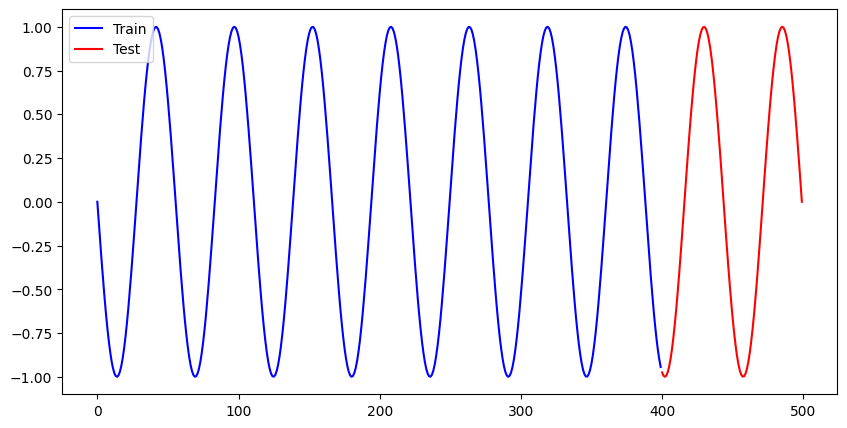

In [7]:
# Sinusoidal Curves - Seasonal stationary data.
def func1(x):
    return np.sin(2 * np.pi * 10 * x)


points = np.linspace(1,50, 500)

# noise = np.random.randn(len(points))
aug_series1 = func1(points)
# aug_series1 = func1(points) + noise

## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()


In [8]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [9]:
X_train_std = torch.Tensor(X_train_std)
X_test_std = torch.Tensor(X_test_std)

X_train_std = rearrange(X_train_std, 'b 1 -> b 1 1')
X_test_std = rearrange(X_test_std, 'b 1 -> b 1 1')

print(X_train_std.shape, X_test_std.shape)
type(X_train_std)

torch.Size([400, 1, 1]) torch.Size([100, 1, 1])


torch.Tensor

In [10]:
X_input = X_train_std[:-1,:,:]
y_input = X_train_std[1:, :, :]
y_input = rearrange(y_input, 'b 1 1 -> b 1')

X_test = X_test_std[:-1,:,:]
y_test = X_test_std[1:,:,:]
y_test = rearrange(y_test, 'b 1 1 -> b 1')

In [11]:
model = PureESNModel(reservoir_size=reservoir_size, input_size=input_size, spectral_radius=spectral_radius, connectivity_rate=connectivity_rate, washout=1, activation =activation)
model.train(X_input, y_input)
y_pred = model.predict(X_test)
print(y_pred.shape)

y_pred = rearrange(y_pred, 'c 1 1 -> c 1')
y_pred = y_pred.numpy()
y_pred.shape


torch.Size([398, 21]) torch.Size([398, 1])
torch.Size([1, 21])
torch.Size([99, 1, 1])


(99, 1)

In [12]:

seasonal_rmse =  np.sqrt(mean_squared_error(y_pred, y_test))
seasonal_mae =  mean_absolute_error(y_pred, y_test)
seasonal_mape = mean_absolute_percentage_error(y_pred, y_test)

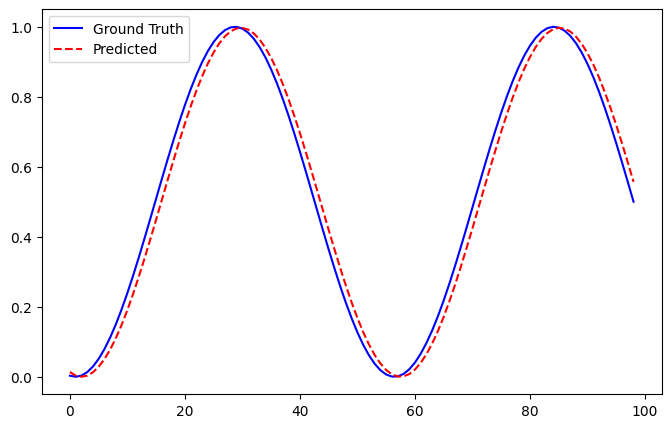

In [13]:
plt.figure(figsize=(8,5))
plt.plot(y_test, label="Ground Truth", c="blue")
plt.plot(y_pred, label="Predicted", c="red", linestyle="--")
plt.legend()
plt.show()

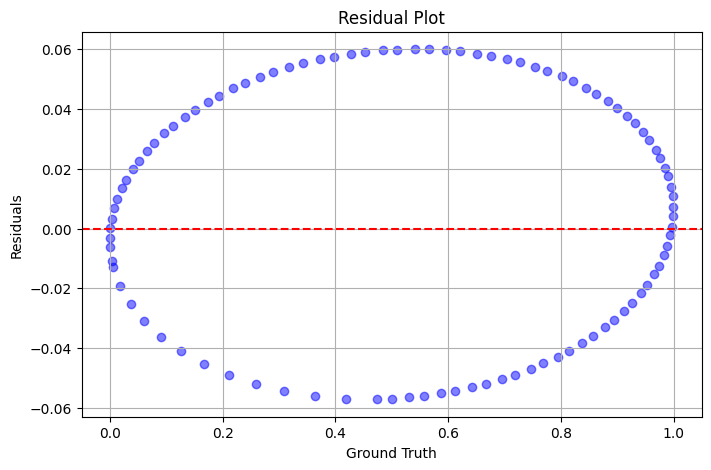

In [14]:
# Calculate residuals
residuals = y_test - y_pred

# Create residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Ground Truth')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

## Augmented Data with Seasonal Stationarity and Linear Trend

(400,)
(100,)


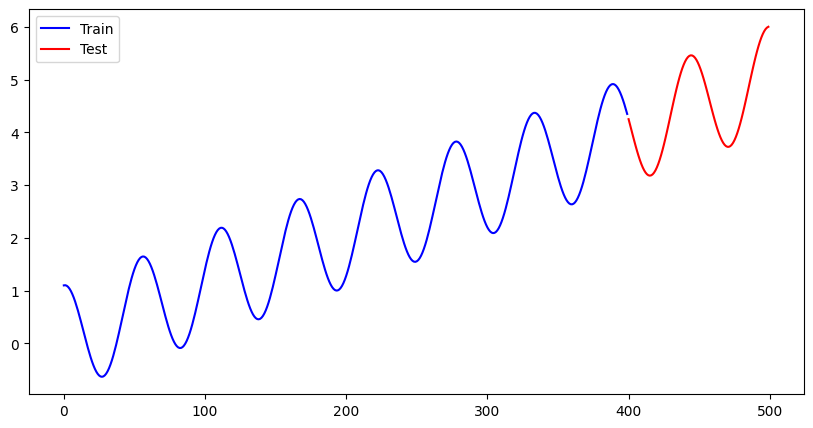

In [15]:
# Sinusoidal Curves - Seasonal stationary data.
def upward_trend_linear(x, frequency=10, amplitude=1, trend_slope=0.1):
    """
    Function that linearly ascends and then descends while maintaining an upward trend.
    
    Parameters:
        x (array-like): Input values.
        ascend_slope (float): Slope of the ascending part of the function.
        descend_slope (float): Slope of the descending part of the function.
        peak_point (float): Point at which the function reaches its peak value.
        
    Returns:
        y (array-like): Output values.
    """
    trend = trend_slope * x
    oscillations = amplitude * np.cos(2 * np.pi * frequency * x)
    y = trend + oscillations
    return y

points = np.linspace(1,50, 500)

aug_series1 = upward_trend_linear(points)


## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()


In [16]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [17]:
X_train_std = torch.Tensor(X_train_std)
X_test_std = torch.Tensor(X_test_std)

X_train_std = rearrange(X_train_std, 'b 1 -> b 1 1')
X_test_std = rearrange(X_test_std, 'b 1 -> b 1 1')

print(X_train_std.shape, X_test_std.shape)
type(X_train_std)

torch.Size([400, 1, 1]) torch.Size([100, 1, 1])


torch.Tensor

In [18]:
X_input = X_train_std[:-1,:,:]
y_input = X_train_std[1:, :, :]
y_input = rearrange(y_input, 'b 1 1 -> b 1')

X_test = X_test_std[:-1,:,:]
y_test = X_test_std[1:,:,:]
y_test = rearrange(y_test, 'b 1 1 -> b 1')

In [19]:
model = PureESNModel(reservoir_size=reservoir_size, input_size=input_size, spectral_radius=spectral_radius, connectivity_rate=connectivity_rate, washout=1, activation =activation)
model.train(X_input, y_input)
y_pred = model.predict(X_test)
print(y_pred.shape)

y_pred = rearrange(y_pred, 'c 1 1 -> c 1')
y_pred = y_pred.numpy()
y_pred.shape


torch.Size([398, 21]) torch.Size([398, 1])
torch.Size([1, 21])
torch.Size([99, 1, 1])


(99, 1)

In [20]:
linear_seasonal_rmse =  np.sqrt(mean_squared_error(y_pred, y_test))
linear_seasonal_mae =  mean_absolute_error(y_pred, y_test)
linear_seasonal_mape = mean_absolute_percentage_error(y_pred, y_test)

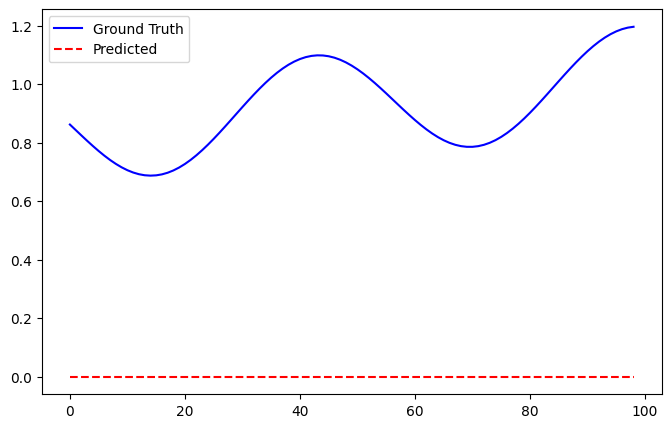

In [21]:
plt.figure(figsize=(8,5))
plt.plot(y_test, label="Ground Truth", c="blue")
plt.plot(y_pred, label="Predicted", c="red", linestyle="--")
plt.legend()
plt.show()

## Augmented Data with Noise only

(400,)
(100,)


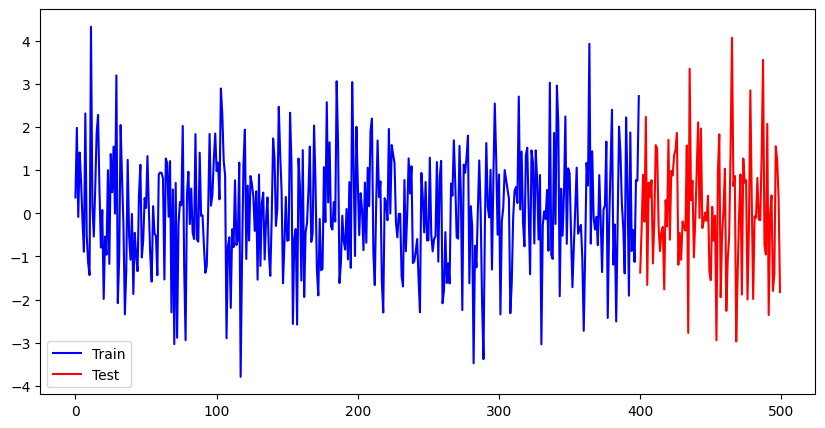

In [22]:
points = np.linspace(1,50, 500)

noise1 = np.random.randn(len(points))
noise2 = np.random.randn(len(points))
noise = noise1 - noise2

aug_series1 = noise

## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()

In [23]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [24]:
X_train_std = torch.Tensor(X_train_std)
X_test_std = torch.Tensor(X_test_std)

X_train_std = rearrange(X_train_std, 'b 1 -> b 1 1')
X_test_std = rearrange(X_test_std, 'b 1 -> b 1 1')

print(X_train_std.shape, X_test_std.shape)
type(X_train_std)

torch.Size([400, 1, 1]) torch.Size([100, 1, 1])


torch.Tensor

In [25]:
X_input = X_train_std[:-1,:,:]
y_input = X_train_std[1:, :, :]
y_input = rearrange(y_input, 'b 1 1 -> b 1')

X_test = X_test_std[:-1,:,:]
y_test = X_test_std[1:,:,:]
y_test = rearrange(y_test, 'b 1 1 -> b 1')

In [26]:
model = PureESNModel(reservoir_size=reservoir_size, input_size=input_size, spectral_radius=spectral_radius, connectivity_rate=connectivity_rate, washout=1, activation =activation)
model.train(X_input, y_input)
y_pred = model.predict(X_test)
print(y_pred.shape)

y_pred = rearrange(y_pred, 'c 1 1 -> c 1')
y_pred = y_pred.numpy()
y_pred.shape


torch.Size([398, 21]) torch.Size([398, 1])
torch.Size([1, 21])
torch.Size([99, 1, 1])


(99, 1)

In [27]:
noise_rmse =  np.sqrt(mean_squared_error(y_pred, y_test))
noise_mae =  mean_absolute_error(y_pred, y_test)
noise_mape = mean_absolute_percentage_error(y_pred, y_test)

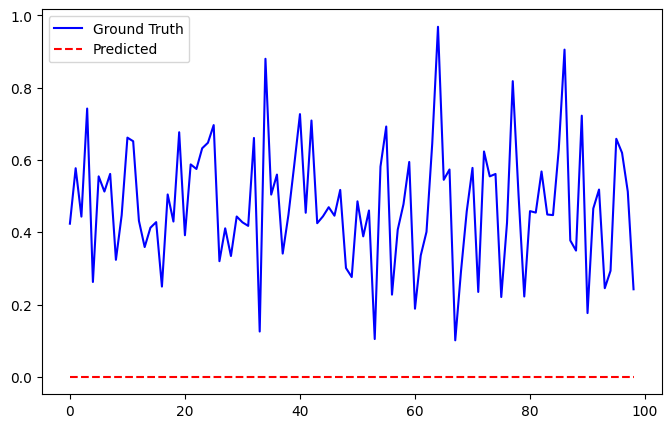

In [28]:
plt.figure(figsize=(8,5))
plt.plot(y_test, label="Ground Truth", c="blue")
plt.plot(y_pred, label="Predicted", c="red", linestyle="--")
plt.legend()
plt.show()

## Augmented data with Seasonality and Noise

(400,)
(100,)


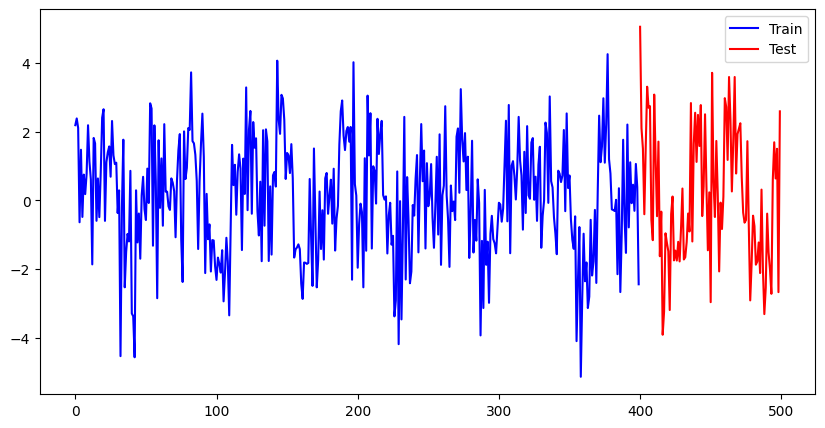

In [29]:
# Sinusoidal Curves - Seasonal stationary data.
def func1(x):
    return np.sin(x) + np.cos(2*x)


points = np.linspace(1,50, 500)

noise1 = np.random.randn(len(points))
noise2 = np.random.randn(len(points))
noise = noise1 - noise2

aug_series1 = func1(points) + noise

## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()

In [30]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [31]:
X_train_std = torch.Tensor(X_train_std)
X_test_std = torch.Tensor(X_test_std)

X_train_std = rearrange(X_train_std, 'b 1 -> b 1 1')
X_test_std = rearrange(X_test_std, 'b 1 -> b 1 1')

print(X_train_std.shape, X_test_std.shape)
type(X_train_std)

torch.Size([400, 1, 1]) torch.Size([100, 1, 1])


torch.Tensor

In [32]:
X_input = X_train_std[:-1,:,:]
y_input = X_train_std[1:, :, :]
y_input = rearrange(y_input, 'b 1 1 -> b 1')

X_test = X_test_std[:-1,:,:]
y_test = X_test_std[1:,:,:]
y_test = rearrange(y_test, 'b 1 1 -> b 1')

In [33]:
model = PureESNModel(reservoir_size=reservoir_size, input_size=input_size, spectral_radius=spectral_radius, connectivity_rate=connectivity_rate, washout=1, activation =activation)
model.train(X_input, y_input)
y_pred = model.predict(X_test)
print(y_pred.shape)

y_pred = rearrange(y_pred, 'c 1 1 -> c 1')
y_pred = y_pred.numpy()
y_pred.shape


torch.Size([398, 21]) torch.Size([398, 1])
torch.Size([1, 21])
torch.Size([99, 1, 1])


(99, 1)

In [34]:
seasonal_noise_rmse =  np.sqrt(mean_squared_error(y_pred, y_test))
seasonal_noise_mae =  mean_absolute_error(y_pred, y_test)
seasonal_noise_mape = mean_absolute_percentage_error(y_pred, y_test)

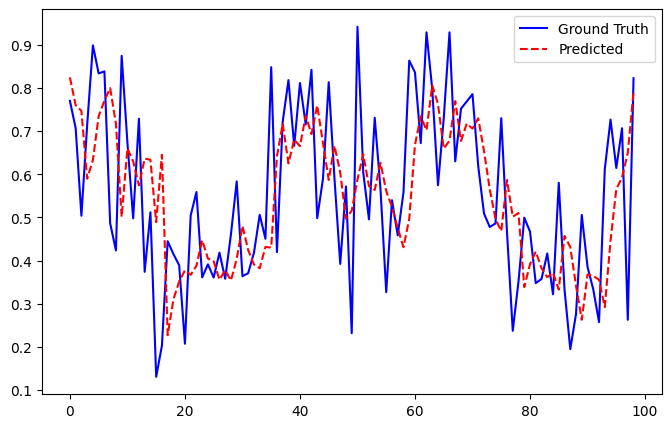

In [35]:
plt.figure(figsize=(8,5))
plt.plot(y_test, label="Ground Truth", c="blue")
plt.plot(y_pred, label="Predicted", c="red", linestyle="--")
plt.legend()
plt.show()

## Augmented data with linear trend

(400,)
(100,)


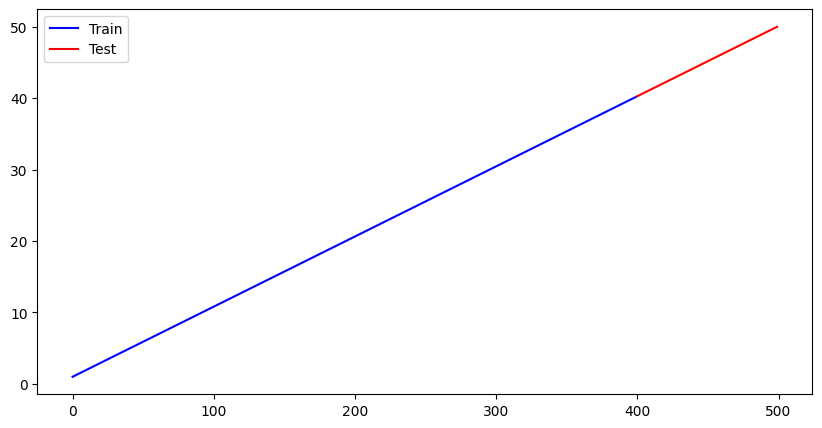

In [36]:
# Sinusoidal Curves - Seasonal stationary data.
def func1(x):
    return x


points = np.linspace(1,50, 500)

noise1 = np.random.randn(len(points))
noise2 = np.random.randn(len(points))
noise = noise1 - noise2

aug_series1 = func1(points)

## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()

In [37]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [38]:
X_train_std = torch.Tensor(X_train_std)
X_test_std = torch.Tensor(X_test_std)

X_train_std = rearrange(X_train_std, 'b 1 -> b 1 1')
X_test_std = rearrange(X_test_std, 'b 1 -> b 1 1')

print(X_train_std.shape, X_test_std.shape)
type(X_train_std)

torch.Size([400, 1, 1]) torch.Size([100, 1, 1])


torch.Tensor

In [39]:
X_input = X_train_std[:-1,:,:]
y_input = X_train_std[1:, :, :]
y_input = rearrange(y_input, 'b 1 1 -> b 1')

X_test = X_test_std[:-1,:,:]
y_test = X_test_std[1:,:,:]
y_test = rearrange(y_test, 'b 1 1 -> b 1')

In [40]:
model = PureESNModel(reservoir_size=reservoir_size, input_size=input_size, spectral_radius=spectral_radius, connectivity_rate=connectivity_rate, washout=1, activation =activation)
model.train(X_input, y_input)
y_pred = model.predict(X_test)
print(y_pred.shape)

y_pred = rearrange(y_pred, 'c 1 1 -> c 1')
y_pred = y_pred.numpy()
y_pred.shape


torch.Size([398, 21]) torch.Size([398, 1])
torch.Size([1, 21])
torch.Size([99, 1, 1])


(99, 1)

In [41]:
linear_rmse =  np.sqrt(mean_squared_error(y_pred, y_test))
linear_mae =  mean_absolute_error(y_pred, y_test)
linear_mape = mean_absolute_percentage_error(y_pred, y_test)

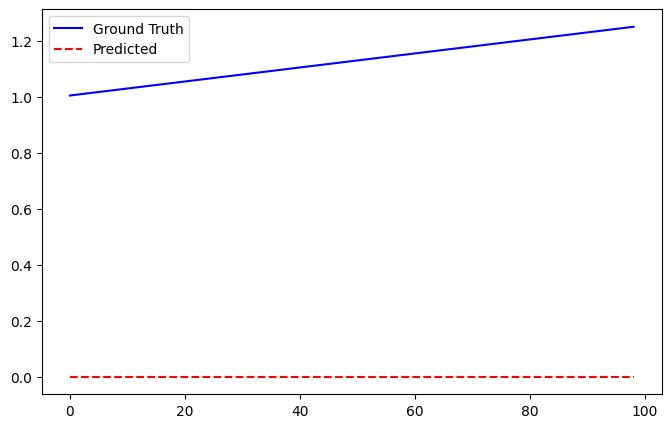

In [42]:
plt.figure(figsize=(8,5))
plt.plot(y_test, label="Ground Truth", c="blue")
plt.plot(y_pred, label="Predicted", c="red", linestyle="--")
plt.legend()
plt.show()

## Augmented Data with Linear Trend and Noise

(400,)
(100,)


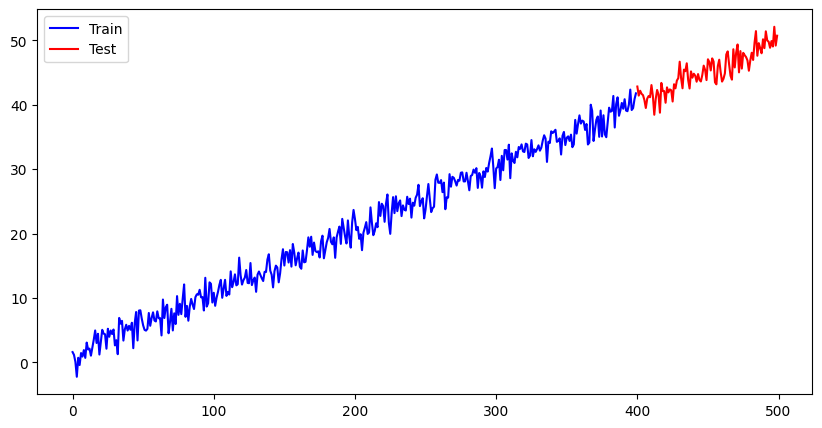

In [43]:
# Sinusoidal Curves - Seasonal stationary data.
def func1(x):
    return x


points = np.linspace(1,50, 500)

noise1 = np.random.randn(len(points))
noise2 = np.random.randn(len(points))
noise = noise1 - noise2

aug_series1 = func1(points) + noise

## Train and Test Splitting of Time Series Data
X = aug_series1
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X_train.shape)
print(X_test.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(X_train)), X_train, c='blue', label='Train')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test, c="red", label='Test')
# plt.plot(X_test, c='red')
plt.legend()
plt.show()

In [44]:
X_train = rearrange(X_train, 'r -> r 1')
X_test = rearrange(X_test, 'r -> r 1')

sc = MinMaxScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [45]:
X_train_std = torch.Tensor(X_train_std)
X_test_std = torch.Tensor(X_test_std)

X_train_std = rearrange(X_train_std, 'b 1 -> b 1 1')
X_test_std = rearrange(X_test_std, 'b 1 -> b 1 1')

print(X_train_std.shape, X_test_std.shape)
type(X_train_std)

torch.Size([400, 1, 1]) torch.Size([100, 1, 1])


torch.Tensor

In [46]:
X_input = X_train_std[:-1,:,:]
y_input = X_train_std[1:, :, :]
y_input = rearrange(y_input, 'b 1 1 -> b 1')

X_test = X_test_std[:-1,:,:]
y_test = X_test_std[1:,:,:]
y_test = rearrange(y_test, 'b 1 1 -> b 1')

In [47]:
model = PureESNModel(reservoir_size=reservoir_size, input_size=input_size, spectral_radius=spectral_radius, connectivity_rate=connectivity_rate, washout=1, activation =activation)
model.train(X_input, y_input)
y_pred = model.predict(X_test)
print(y_pred.shape)

y_pred = rearrange(y_pred, 'c 1 1 -> c 1')
y_pred = y_pred.numpy()
y_pred.shape


torch.Size([398, 21]) torch.Size([398, 1])
torch.Size([1, 21])
torch.Size([99, 1, 1])


(99, 1)

In [48]:
linear_noise_rmse =  np.sqrt(mean_squared_error(y_pred, y_test))
linear_noise_mae =  mean_absolute_error(y_pred, y_test)
linear_noise_mape = mean_absolute_percentage_error(y_pred, y_test)

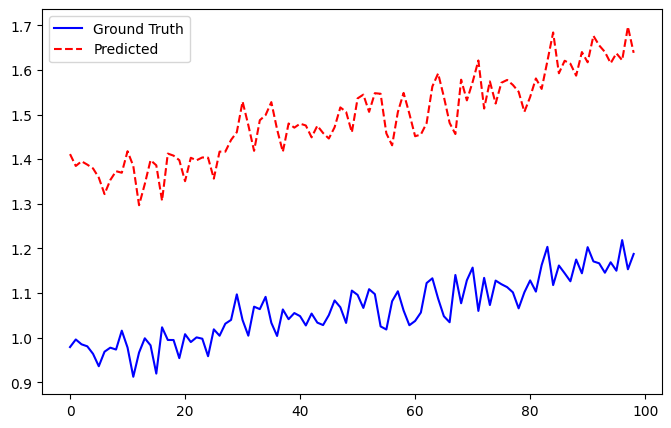

In [49]:
plt.figure(figsize=(8,5))
plt.plot(y_test, label="Ground Truth", c="blue")
plt.plot(y_pred, label="Predicted", c="red", linestyle="--")
plt.legend()
plt.show()